In [1]:
import os

import pandas as pd
import numpy as np

from glob import glob
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import tensorflow as tf
from keras.utils import to_categorical # convert to one-hot-encoding

import warnings
warnings.filterwarnings('ignore')
import cv2

from utils import *

In [2]:
# Load data
project_path = 'C:\\Users\\marce\\Documents\\DeepLearningProject\\'

# As we know, there are 2 folders with images, one for training and one for testing, and there is also the metadata of all those pictures in a single excel file.
# Let's load the csv file and see what it looks like.

df = pd.read_csv(project_path + 'HAM10000_metadata.csv')

# Now to get all the images from the train folder
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(project_path, '*', '*.jpg'))}

In [3]:
# Now we can add a new column to the dataframe with the path to the image
df['path'] = df['image_id'].map(imageid_path_dict.get)

# We can also add a column with the actual image
df['image'] = df['path'].map(lambda x: cv2.imread(x))

# Let's now separate the dataset into train and test based on whether train or test is in the path
df_train = df[df['path'].str.contains("train")]
df_test = df[df['path'].str.contains("test")]

In [28]:
# Export the dataframes to csv
df_train.to_csv('C:\\Users\\marce\\OneDrive\\Documentos\\GitHub\\Deep-Learning-Project\\PracticalClasses\\ProjectDataTemp\\' + 'df_train_cv2.csv', index=False) 
df_test.to_csv('C:\\Users\\marce\\OneDrive\\Documentos\\GitHub\\Deep-Learning-Project\\PracticalClasses\\ProjectDataTemp\\' + 'df_test_cv2.csv', index=False)

In [4]:
# Check if there are duplicates in the dataset by the image_id, which should be unique.
# We can do this be checking if the number of unique values is the same as the number of rows
df_train['image_id'].value_counts()

image_id
ISIC_0027419    1
ISIC_0025774    1
ISIC_0027501    1
ISIC_0026819    1
ISIC_0027757    1
               ..
ISIC_0028827    1
ISIC_0032366    1
ISIC_0027124    1
ISIC_0025221    1
ISIC_0032258    1
Name: count, Length: 7511, dtype: int64

In [4]:
# Because using categorical data is not the best approach, we will use LabelEncoder to transform the target column into numerical values, which we will then use to_categorical to transform into one-hot encoding.
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_train['CancerType'] = label_encoder.fit_transform(df_train['dx'])
df_test['CancerType'] = label_encoder.fit_transform(df_test['dx'])

In [9]:
df_train.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image,CancerType
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\marce\Documents\DeepLearningProject\t...,"[[[191, 147, 188], [189, 148, 186], [191, 150,...",2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\marce\Documents\DeepLearningProject\t...,"[[[23, 15, 25], [22, 14, 25], [22, 14, 25], [2...",2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\marce\Documents\DeepLearningProject\t...,"[[[140, 128, 186], [136, 128, 188], [133, 126,...",2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\marce\Documents\DeepLearningProject\t...,"[[[16, 9, 24], [15, 11, 22], [15, 11, 23], [16...",2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\marce\Documents\DeepLearningProject\t...,"[[[102, 80, 122], [104, 82, 124], [106, 83, 12...",2


In [33]:
df_train['dx'].value_counts()

dx
nv       5029
mel       835
bkl       824
bcc       385
akiec     245
vasc      107
df         86
Name: count, dtype: int64

In [34]:
df_train['CancerType'].value_counts()


CancerType
5    5029
4     835
2     824
1     385
0     245
6     107
3      86
Name: count, dtype: int64

### Balancing the Dataset
As we saw before, the dataset is not balanced, so we should balance it before training the model.
Some of the approaches we can use are:
- Undersampling
- Oversampling
- SMOTE
- Class Weights
- Ensemble Methods
- Data Augmentation

In [5]:

# We should extract the target column from both train and test and remove it from the dataframes
y_train = df_train[['image_id', 'CancerType']]
y_train.set_index('image_id', inplace=True)
y_train = to_categorical(y_train, num_classes = 7)

y_test = df_test[['image_id', 'CancerType']]
y_test.set_index('image_id', inplace=True)
y_test = to_categorical(y_test, num_classes = 7)

X = df_train.drop(['dx', 'CancerType'], axis=1)
X.set_index('image_id', inplace=True)

X_test = df_test.drop(['dx', 'CancerType'], axis=1)
X_test.set_index('image_id', inplace=True)


In [19]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_integers),
                                                  y = y_integers)
d_class_weights = dict(enumerate(class_weights))


In [26]:
d_class_weights

{0: 4.3795918367346935,
 1: 2.787012987012987,
 2: 1.3021844660194175,
 3: 12.476744186046512,
 4: 1.2850299401197605,
 5: 0.21336249751441638,
 6: 10.02803738317757}

In [6]:
df_train.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image,CancerType
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\marce\Documents\DeepLearningProject\t...,"[[[191, 147, 188], [189, 148, 186], [191, 150,...",2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\marce\Documents\DeepLearningProject\t...,"[[[23, 15, 25], [22, 14, 25], [22, 14, 25], [2...",2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\marce\Documents\DeepLearningProject\t...,"[[[140, 128, 186], [136, 128, 188], [133, 126,...",2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\marce\Documents\DeepLearningProject\t...,"[[[16, 9, 24], [15, 11, 22], [15, 11, 23], [16...",2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\marce\Documents\DeepLearningProject\t...,"[[[102, 80, 122], [104, 82, 124], [106, 83, 12...",2


In [7]:
X.head()

,lesion_id,dx_type,age,sex,localization,path,image
image_id,,,,,,,
ISIC_0027419,HAM_0000118,histo,80.0,male,scalp,C:\Users\marce\Documents\DeepLearningProject\t...,"[[[191, 147, 188], [189, 148, 186], [191, 150,..."
ISIC_0025030,HAM_0000118,histo,80.0,male,scalp,C:\Users\marce\Documents\DeepLearningProject\t...,"[[[23, 15, 25], [22, 14, 25], [22, 14, 25], [2..."
ISIC_0026769,HAM_0002730,histo,80.0,male,scalp,C:\Users\marce\Documents\DeepLearningProject\t...,"[[[140, 128, 186], [136, 128, 188], [133, 126,..."
ISIC_0025661,HAM_0002730,histo,80.0,male,scalp,C:\Users\marce\Documents\DeepLearningProject\t...,"[[[16, 9, 24], [15, 11, 22], [15, 11, 23], [16..."
ISIC_0031633,HAM_0001466,histo,75.0,male,ear,C:\Users\marce\Documents\DeepLearningProject\t...,"[[[102, 80, 122], [104, 82, 124], [106, 83, 12..."


In [9]:
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [8]:
# Convert the images to numpy arrays
X_image = np.asarray(X['image'].tolist())
X_test_image = np.asarray(X_test['image'].tolist())

In [28]:
X_image.shape

(7511, 450, 600, 3)

In [13]:
X_image

array([[[[191, 147, 188],
         [189, 148, 186],
         [191, 150, 187],
         ...,
         [171, 155, 196],
         [170, 156, 197],
         [168, 157, 197]],

        [[193, 149, 186],
         [194, 152, 187],
         [191, 153, 189],
         ...,
         [169, 156, 194],
         [169, 159, 195],
         [168, 159, 192]],

        [[192, 148, 185],
         [195, 152, 189],
         [196, 153, 190],
         ...,
         [169, 155, 196],
         [171, 157, 198],
         [169, 156, 194]],

        ...,

        [[155, 124, 157],
         [154, 121, 156],
         [154, 124, 159],
         ...,
         [161, 146, 177],
         [159, 144, 176],
         [155, 141, 175]],

        [[151, 122, 155],
         [154, 123, 156],
         [152, 123, 156],
         ...,
         [163, 147, 178],
         [159, 144, 175],
         [159, 142, 175]],

        [[151, 119, 154],
         [149, 120, 153],
         [152, 121, 154],
         ...,
         [167, 147, 176],
        

## 2. Verify data quality

In [39]:
def get_image_dimensions(image_list):
    """
    This function prints the largest and smallest dimensions of the images in the list
    Args:
        image_list: list of images
    """
    
    # List for storing image dimensions
    largest_width, largest_height = 0, 0
    smallest_width, smallest_height = float('inf'), float('inf')
    
    for image in image_list:
        # Get the width and height of the image
        height, width, _ = image.shape
    
        # Update largest and smallest dimensions if necessary
        largest_width = max(largest_width, width)
        largest_height = max(largest_height, height)
        smallest_width = min(smallest_width, width)
        smallest_height = min(smallest_height, height)
        
    print("Largest Image : {}x{}".format(largest_width, largest_height))
    print("Smallest Image : {}x{}".format(smallest_width, smallest_height))

In [40]:
get_image_dimensions(X_image)

Largest Image : 600x450
Smallest Image : 600x450


All images have the same size, so we don't need to resize them.

## 3. Image Enhancement

In [6]:
def apply_contrast_enhancement(images_data, size = (299, 224), alpha = 1.3, beta = 0.5, display = False):
    """
    This function applies contrast enhancement to the images in a dataset.
    Args:
        images_data: list of images
        size: size to which the images should be resized
        alpha: contrast control (1.0 means no change)
        beta: brightness control (0 means no change)
        display: whether to display the images before and after the contrast enhancement
    Returns:
        images_data_processed: numpy array of processed images
    """

    # Lists to store the processed images
    images_data_processed = []

    # Apply contrast enhancement to each image
    for img in images_data:
        # Resize it
        img = cv2.resize(img, size)

        # Apply contrast enhancement
        enhanced_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

        # Append the processed image to the list
        images_data_processed.append(enhanced_img)

    # Convert the processed lists to numpy arrays
    images_data_processed = np.array(images_data_processed)

    # Display first 6 images and compare them with the original images
    if display:
        fig, ax = plt.subplots(1, 6, figsize=(15, 15))
        for i in range(6):
            ax[i].imshow(images_data[i])
            ax[i].set_title("Original Image")
        plt.show()

        fig, ax = plt.subplots(1, 6, figsize=(15, 15))
        for i in range(6):
            ax[i].imshow(images_data_processed[i])
            ax[i].set_title("Contrast Enhanced Image")
        plt.show()
    return images_data_processed


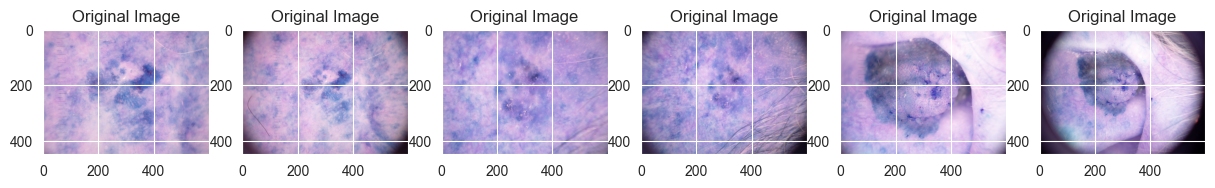

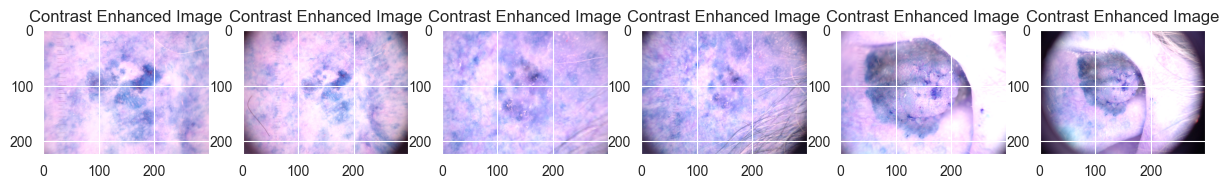

In [9]:
X_processed = apply_contrast_enhancement(X_image,alpha = 1.15, beta=4, display=True)

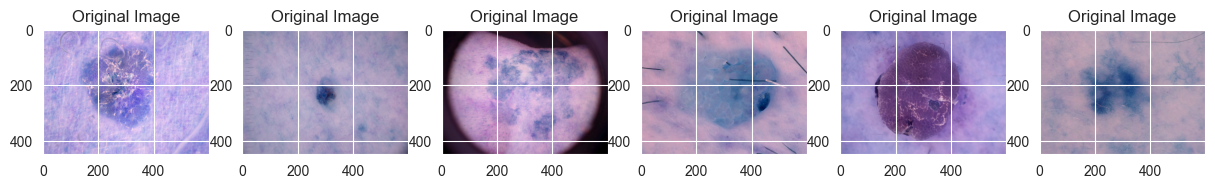

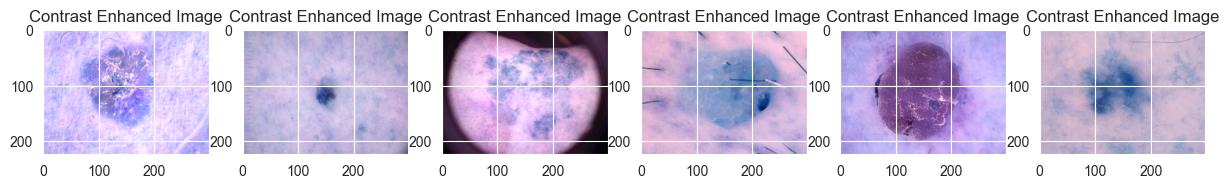

In [9]:
X_test_processed = apply_contrast_enhancement(X_test_image,alpha = 1.15, beta=4, display=True)

## 4. Image Data Augmentation

In [12]:
from keras.preprocessing.image import ImageDataGenerator

IDG = ImageDataGenerator(rescale= 1./255,
                             rotation_range=35,  # randomly rotate images in the range (degrees, 0 to 180)
                             zoom_range = 0.12, # Randomly zoom image
                             width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=True # randomly flip images
                                )   

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_processed, y_train, test_size=0.2, stratify=y_train, shuffle=True)


In [13]:
IDG.fit(X_train)

In [35]:
X_processed.shape

(7511, 224, 299, 3)

In [36]:
X_image.shape

(7511, 450, 600, 3)

In [24]:
from keras.models import Sequential
import tensorflow
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import (
    ResNet50,
    InceptionV3,
    DenseNet121,
    VGG16,
    Xception)


base_model= tensorflow.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 299, 3),
    pooling=None,
)

for layer in base_model.layers:
    layer.trainable = False


model=Sequential()
model.add(base_model)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dense(728, activation='relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(728, activation='relu'))
model.add(Dense(7, activation='softmax'))


early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [25]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(IDG.flow(X_train, Y_train, batch_size=128), epochs=7 , validation_data=(X_val, Y_val), callbacks=[early_stop] )

Epoch 1/7
47/47 [==============================] - 427s 9s/step - loss: 1.2374 - accuracy: 0.6381 - val_loss: 4.3306 - val_accuracy: 0.6121
Epoch 2/7
47/47 [==============================] - 430s 9s/step - loss: 0.8902 - accuracy: 0.6821 - val_loss: 11.6759 - val_accuracy: 0.2069
Epoch 3/7
47/47 [==============================] - 431s 9s/step - loss: 0.8392 - accuracy: 0.6961 - val_loss: 12.2256 - val_accuracy: 0.2608
Epoch 4/7
26/47 [===============>..............] - ETA: 2:35 - loss: 0.8102 - accuracy: 0.7057

KeyboardInterrupt: 

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(IDG.flow(X_processed, y_train, batch_size=32), epochs=5, callbacks=[early_stop], class_weight=d_class_weights, validation_split=0.2)

In [45]:
history.history['val_accuracy'][-1]

NameError: name 'history' is not defined

In [23]:
# Let's now split the train dataset into train and validation
#X_train, X_val, y_train_2, y_val = train_test_split(df_train, y_train, test_size=0.2, random_state=42, stratify=y_train, shuffle=True)

In [24]:
#y_train_2.value_counts()

# 1. Class Weights

In [25]:
# We can see that the dataset is not balanced at all, so we should use class weights to compensate for that
from sklearn.utils import class_weight

#class_weights = class_weight.compute_class_weight('balanced',
#                                                 np.unique(y_train_2),
 #                                                y_train_2)

#class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
